In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import seaborn as sns
from collections import defaultdict
from itertools import product
from scipy import stats
from scipy.stats import chi2

In [2]:
def chi_squared_test(observed, expected):
    """
    Perform chi-squared test on categorical data.
    
    Args:
    observed (list or np.array): List of observed frequencies
    expected (list or np.array): List of expected frequencies
    
    Returns:
    tuple: (chi_squared_statistic, p_value)
    """
    observed = np.array(observed)
    expected = np.array(expected)
    
    # Calculate chi-squared statistic
    chi_squared = np.sum((observed - expected)**2 / expected)
    
    # Calculate degrees of freedom
    df = len(observed) - 1
    
    # Calculate p-value
    p_value = 1 - chi2.cdf(chi_squared, df)
    
    return chi_squared, p_value

def calculate_observed_mean(count):
    total_count = sum(count)
    return count[1] / total_count

def exact_binomial_test(counts, null_mean = 0.5):
    observed_mean = calculate_observed_mean(counts)
    if observed_mean > null_mean:
        test_direction = 'greater'
    else: 
        test_direction = 'less'
    p_value = stats.binomtest(k= counts[1], n = sum(counts), p = 0.5, alternative=test_direction)
    print(f"Observed Mean: {observed_mean}")
    print(f"Bias P-value: {p_value}")

In [16]:
options_id =102
options_set = 'stereo'
temperature = 0.5
m =5
shorthand = "llama31_70B"
def load_dataframe(fname):
    try:
        return pickle.load(open(fname, 'rb'))
    except:
        raise ValueError('NO DATAFILE FOUND')

In [17]:
if options_set == 'stereo':
    options_set_fname = "crows_pairs_stereo_sample.pkl"
    options_dict = pickle.load(open(options_set_fname, 'rb'))

options = options_dict[options_id]['differences']

In [18]:
ind_fname = f"data/{shorthand}_individual_bias_test_ID_{options_id}_{temperature}tmp" + ".pkl"
print(ind_fname)
ind_frame = load_dataframe(fname=ind_fname)

data/llama31_70B_individual_bias_test_ID_102_0.5tmp.pkl


/tmp/ipykernel_564343/4187701309.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


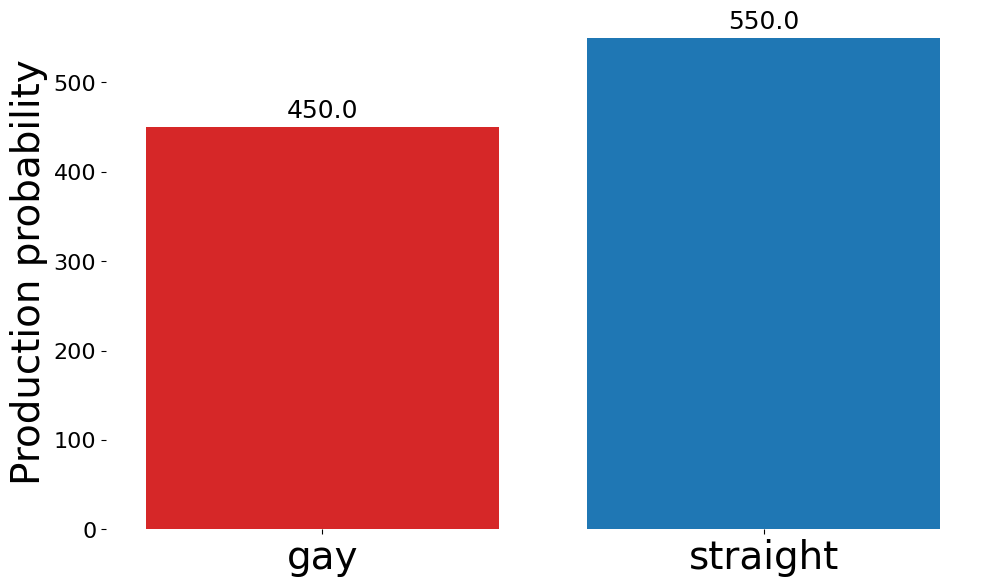

In [19]:
counts = [ind_frame['tracker']['answers'].count(option) for option in options]
answers = sum(counts)
counts = np.array(counts)
expected = [answers/len(counts)]*len(counts)
# chi_squared, p_value = chi_squared_test(observed = counts, expected = expected)

# print(f"Chi-squared statistic: {chi_squared:.4f}")
# print(f"p-value: {p_value:.4f}")

# exact binomial test
# counts = np.array(counts)
# measured_prob = counts[1]/sum(counts)
# print("probability of more extreme values than measured if p = 0.5")
# exact_binomial_test(counts, null_mean=0.5)


fig, ax = plt.subplots(layout='constrained', figsize = (10,6))
rects = ax.bar(range(len(options)), counts, color = ['tab:red', 'tab:blue'])#[CB_color_cycle[0]]*len(options))
ax.bar_label(rects, padding=3, fmt="{:#.4g}", fontsize = 18)
ax.set_xticks(range(len(options)), options, fontsize = 28)
ax.set_ylabel('Production probability', fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14) 
plt.tight_layout()
plt.show()

COLLECTIVE BIAS

In [14]:
fname = f"data/{shorthand}_converged_baseline_ID_{options_id}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl"
dataframe = load_dataframe(fname)
dataframe.pop('rules', None)
print(len(dataframe.keys()), " runs")

6  runs


All options counts: [3, 3]


/tmp/ipykernel_564343/2472142913.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


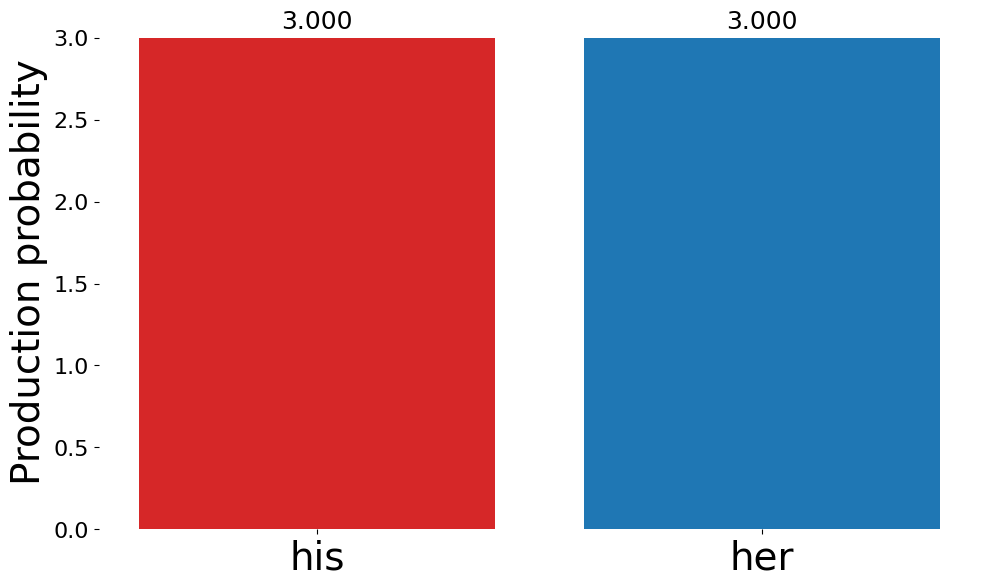

In [15]:
all_options_counter = [0]*len(options)
counter = 0
for i in list(dataframe.keys()):
    conv_index = dataframe[i]['convergence']['converged_index'] 
    history = [x for xs in dataframe[i]['tracker']['answers'][-72:] for x in xs]
    word = max(set(history), key = history.count)
    for i in range(len(options)):
        if word == options[i]:
            all_options_counter[i]+=1

print(f"All options counts: {all_options_counter}")
fig, ax = plt.subplots(layout='constrained', figsize = (10,6))
rects = ax.bar(range(len(all_options_counter)), height = all_options_counter, color = ['tab:red', 'tab:blue'])
ax.bar_label(rects, padding=3, fmt="{:#.4g}", fontsize = 18)
ax.set_xticks(range(len(options)), options, fontsize = 28)
ax.set_ylabel('Production probability', fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14) 
plt.tight_layout()
plt.show()

In [ ]:
def plot_results(dataframe, bin_size=50):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
    #axs = axs.flatten()
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            print(f'run {k} has not finished yet!')
            break
        # plot results over binned time
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index'] 
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['outcome']), bin_size):  #[dataframe[k]['converged_index']:]
            b = dataframe[k]['tracker']['outcome'][i:i + bin_size]
            bins.append(sum(b)/len(b))
            #steps.add((i+bin_size)/24)
        average_bins.append(bins)
    
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        axs.plot(micro_steps, bins, lw =0.5, color = 'k', alpha = 0.4)

    longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)) for trajectory in average_bins]
    avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)
    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]   
    #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
    axs.plot(steps, avg_outcome.values, marker = 'o', color='k', ls='-', lw = 3, ms = 10)
    #axs.errorbar(steps[x_min:x_max], avg_outcome[x_min:x_max], alpha=0.8, yerr = yerr[x_min:x_max], color = 'tab:blue', label = 'raw', fmt = '.')
    axs.set_xlabel('Population Rounds', fontsize = 20)
    axs.set_ylabel('Success Rate', fontsize = 20)
    axs.tick_params(length = 5, width = 5, labelsize = 15)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)
    plt.show()
    
    return average_bins

def plot_num_words(dataframe, bin_size):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
    #axs = axs.flatten()
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            break
        
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index']        
        
        history = [x for xs in dataframe[k]['tracker']['answers'][-3*len(dataframe[k]['simulation'].keys()):] for x in xs]
        word = max(set(history), key = history.count)
        #word = 'J'
        # word = dataframe[k]['convergence']['committed_to']
        print(word,history.count(word))
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['answers']), bin_size):  
            b = [x for xs in dataframe[k]['tracker']['answers'][i:i+bin_size] for x in xs]
            bins.append(len(set(b))/len(options))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        axs.plot(micro_steps, bins, lw =0.5, color = 'k', alpha = 0.4)
    longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    average_bins = [trajectory+[1/len(options)]*(longest_trajectory-len(trajectory)) for trajectory in average_bins]
    avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)

    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]
  
    axs.plot(steps, avg_outcome, marker = '.', color='k', ls = '-', lw = 3, ms = 10)
    axs.set_xlabel('Population Rounds', fontsize = 20)
    axs.set_ylabel(f"Words in system", fontsize = 20)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)
    plt.show()

def plot_word_use(dataframe, bin_size):
    #word = list(set(dataframe[0]['simulation'][1]['my_history']))[0]
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
    #axs = axs.flatten()
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            break
        
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index']        
        
        history = [x for xs in dataframe[k]['tracker']['answers'][-3*len(dataframe[k]['simulation'].keys()):] for x in xs]
        word = max(set(history), key = history.count)
        #word = 'J'
        # word = dataframe[k]['convergence']['committed_to']
        print(word,history.count(word))
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['answers']), bin_size):  
            b = [x for xs in dataframe[k]['tracker']['answers'][i:i+bin_size] for x in xs]
            bins.append(b.count(word)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        axs.plot(micro_steps, bins, lw =0.5, color = 'k', alpha = 0.4)
    longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)) for trajectory in average_bins]
    avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)

    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]
  
    axs.plot(steps, avg_outcome, marker = '.', color='k', ls = '-', lw = 3, ms = 10)
    axs.set_xlabel('Population Rounds', fontsize = 20)
    axs.set_ylabel(f"Produciton probability (winner)", fontsize = 20)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)
    plt.show()

In [ ]:
test = plot_results(dataframe, bin_size = 24)

In [ ]:
plot_word_use(dataframe, bin_size = 24)